In [1]:
# 1. Install required libraries (run this cell first!)
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [4]:
# 3. Load your data
print("Loading your Weekly.csv data...")
try:
    df = pd.read_csv('Weekly.csv')
    print("✅ Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please make sure:")
    print("1. Weekly.csv is in the same folder as this notebook")
    print("2. The file name is exactly 'Weekly.csv'")

Loading your Weekly.csv data...
✅ Data loaded successfully!
Dataset shape: (104, 12)

First 5 rows:


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [5]:
# 4. Explore your data
print("📊 Exploring your data...")
print(f"\nNumber of weeks: {len(df)}")
print("\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

print("\n🔍 Missing values:")
missing = df.isnull().sum()
print(missing[missing > 0])
if missing.sum() == 0:
    print("✅ No missing values!")

📊 Exploring your data...

Number of weeks: 104

Column names:
  - week
  - facebook_spend
  - google_spend
  - tiktok_spend
  - instagram_spend
  - snapchat_spend
  - social_followers
  - average_price
  - promotions
  - emails_send
  - sms_send
  - revenue

🔍 Missing values:
Series([], dtype: int64)
✅ No missing values!


📈 Revenue trend over time:


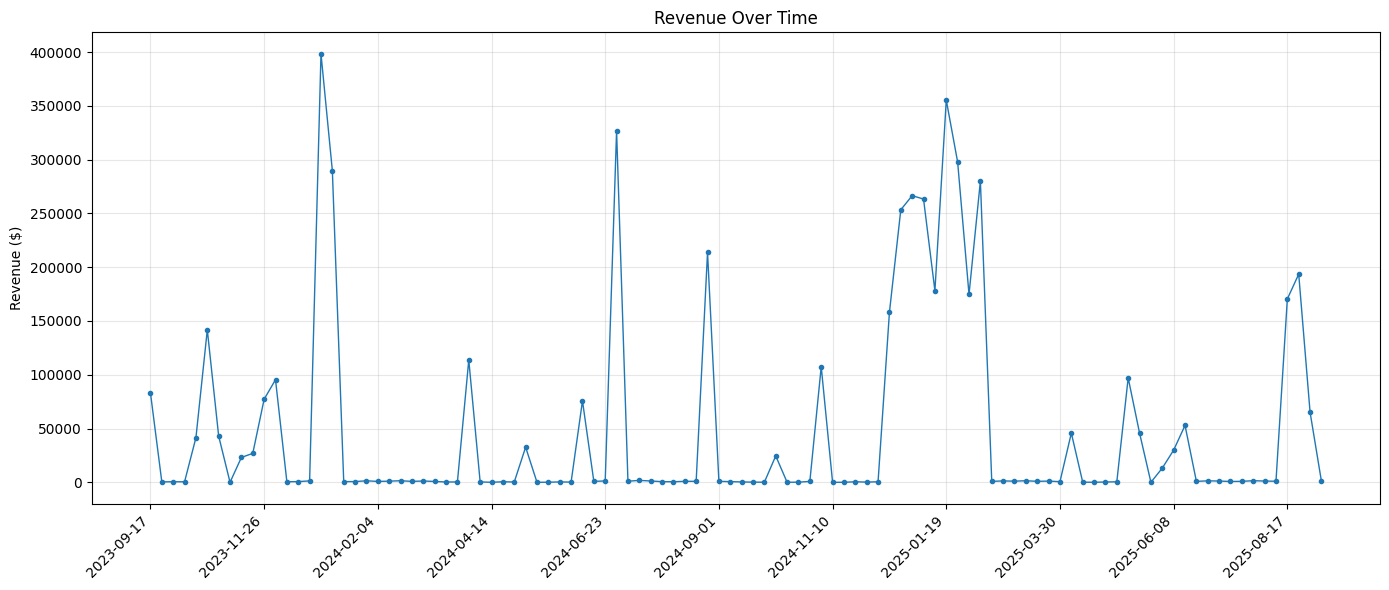

📊 Revenue Statistics:
   Average weekly revenue: $49,054
   Highest weekly revenue: $398,454
   Lowest weekly revenue: $1
   Total revenue period: $5,101,610


In [7]:
# 5. Visualize revenue trend with proper x-axis labels
print("📈 Revenue trend over time:")

plt.figure(figsize=(14, 6))

if 'week' in df.columns:
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['week']):
        df['week'] = pd.to_datetime(df['week'])
    
    plt.plot(df['week'], df['revenue'], marker='o', markersize=3, linewidth=1)
    plt.xticks(rotation=45, ha='right')
    
    # Show only some labels to avoid crowding
    n = len(df['week'])
    if n > 20:  # If many data points, show fewer labels
        step = max(1, n // 10)  # Show ~10 labels
        plt.xticks(df['week'][::step], df['week'].dt.strftime('%Y-%m-%d')[::step], rotation=45, ha='right')
    else:
        plt.xticks(rotation=45, ha='right')
        
else:
    # If no date column, use index numbers
    plt.plot(df.index, df['revenue'], marker='o', markersize=3, linewidth=1)
    plt.xlabel('Week Number')

plt.title('Revenue Over Time')
plt.ylabel('Revenue ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also show basic stats
print(f"📊 Revenue Statistics:")
print(f"   Average weekly revenue: ${df['revenue'].mean():,.0f}")
print(f"   Highest weekly revenue: ${df['revenue'].max():,.0f}")
print(f"   Lowest weekly revenue: ${df['revenue'].min():,.0f}")
print(f"   Total revenue period: ${df['revenue'].sum():,.0f}")

💰 Found marketing spend columns: ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']


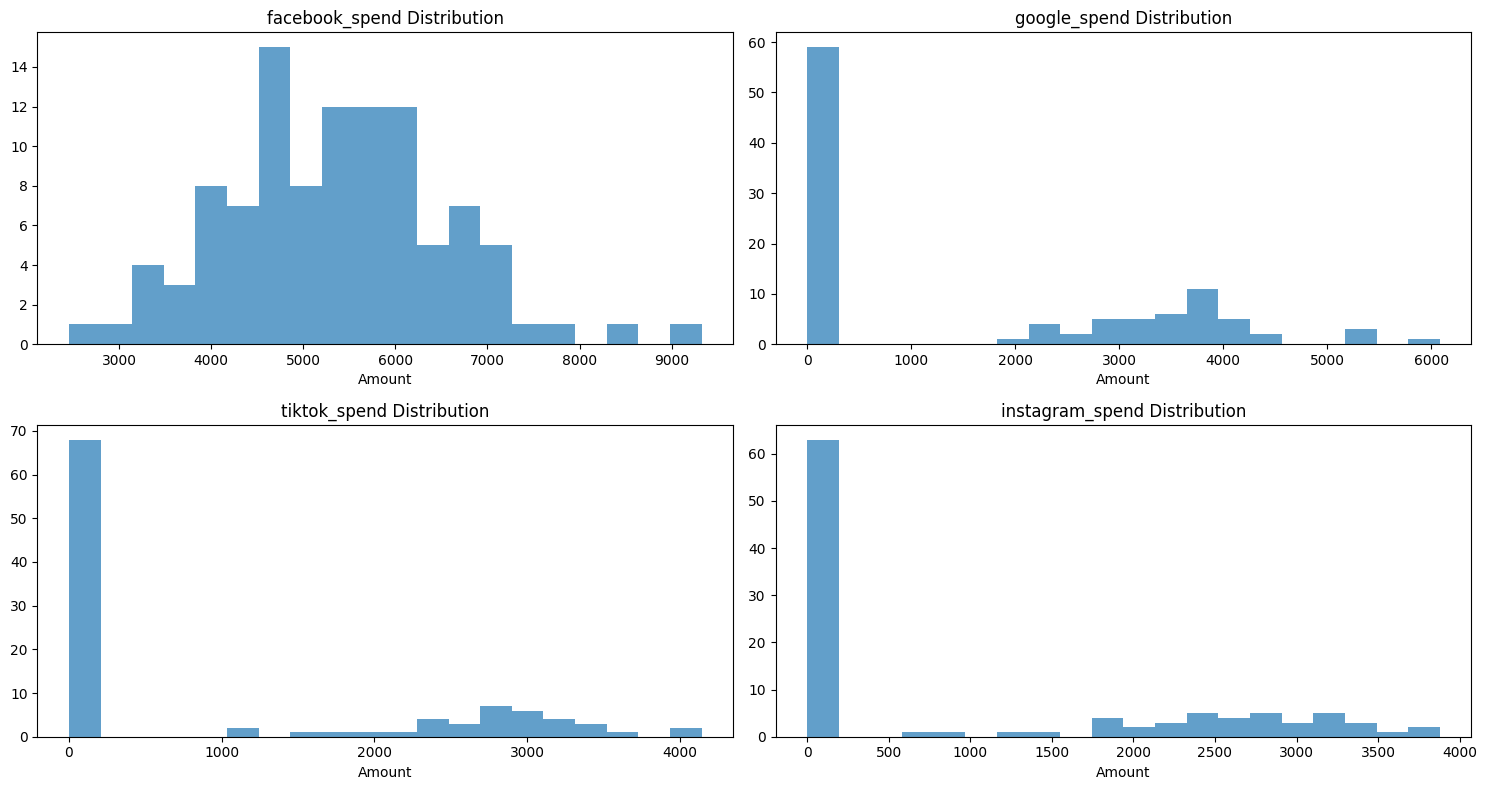

In [8]:
# 6. Find marketing spend columns
spend_columns = [col for col in df.columns if any(word in col.lower() for word in ['spend', 'cost', 'investment'])]
print(f"💰 Found marketing spend columns: {spend_columns}")

if spend_columns:
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(spend_columns[:4], 1):
        plt.subplot(2, 2, i)
        plt.hist(df[col], bins=20, alpha=0.7)
        plt.title(f'{col} Distribution')
        plt.xlabel('Amount')
    plt.tight_layout()
    plt.show()

In [9]:
# 7. Create smart features for marketing effects
print("🔧 Creating smart marketing features...")

# Adstock effect (carryover)
def adstock_transform(series, decay=0.5):
    """Model how marketing effects carry over time"""
    transformed = np.zeros_like(series)
    for i in range(len(series)):
        for lag in range(min(i, 4) + 1):
            transformed[i] += series[i - lag] * (decay ** lag)
    return transformed

# Diminishing returns
def diminishing_returns(series):
    """Model how additional spending has less impact"""
    return np.log1p(series / 1000)

# Apply to each spend column
for col in spend_columns:
    df[f'{col}_adstock'] = adstock_transform(df[col])
    df[f'{col}_saturated'] = diminishing_returns(df[f'{col}_adstock'])
    print(f"✅ Processed {col}")

print("✅ All features created!")

🔧 Creating smart marketing features...
✅ Processed facebook_spend
✅ Processed google_spend
✅ Processed tiktok_spend
✅ Processed instagram_spend
✅ Processed snapchat_spend
✅ All features created!


In [10]:
# 8. Prepare for modeling
print("🎯 Preparing for machine learning...")

# Find feature columns
feature_columns = [col for col in df.columns if ('saturated' in col) or ('price' in col.lower()) or ('promo' in col.lower())]
target_column = 'revenue'

X = df[feature_columns]
y = df[target_column]

print(f"Features: {feature_columns}")
print(f"Target: {target_column}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

🎯 Preparing for machine learning...
Features: ['average_price', 'promotions', 'facebook_spend_saturated', 'google_spend_saturated', 'tiktok_spend_saturated', 'instagram_spend_saturated', 'snapchat_spend_saturated']
Target: revenue
X shape: (104, 7), y shape: (104,)


In [11]:
# 9. Scale features and train model
print("🤖 Training the model...")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = ElasticNet(alpha=0.1, random_state=42)
model.fit(X_scaled, y)

# Get feature importance
importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_,
    'importance': np.abs(model.coef_)
}).sort_values('importance', ascending=False)

print("✅ Model trained!")
print("\n📊 Feature Importance:")
display(importance)

🤖 Training the model...
✅ Model trained!

📊 Feature Importance:


,feature,coefficient,importance
5,instagram_spend_saturated,63218.128143,63218.128143
0,average_price,-42919.492166,42919.492166
3,google_spend_saturated,-8900.733264,8900.733264
4,tiktok_spend_saturated,-5299.625924,5299.625924
2,facebook_spend_saturated,-1886.545645,1886.545645
6,snapchat_spend_saturated,-1606.089513,1606.089513
1,promotions,-913.166078,913.166078


📈 Visualizing what drives revenue...


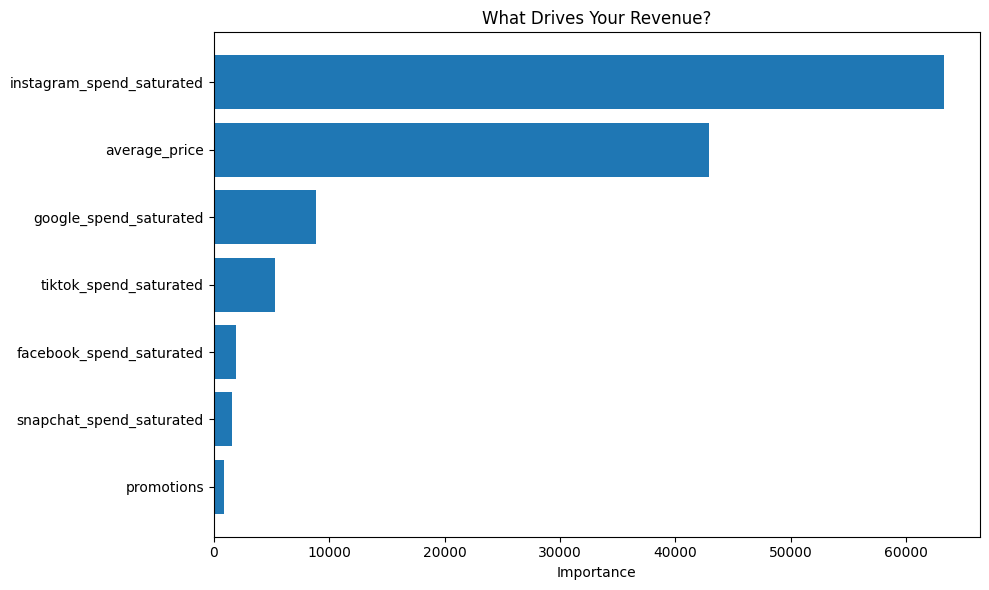

In [12]:
# 10. Visualize feature importance
print("📈 Visualizing what drives revenue...")
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('What Drives Your Revenue?')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# 11. Calculate ROI for each channel
print("💰 Calculating ROI for each marketing channel...")

roi_results = []
for col in feature_columns:
    if 'saturated' in col:
        original_col = col.replace('_saturated', '').replace('_adstock', '')
        if original_col in df.columns:
            total_spend = df[original_col].sum()
            revenue_impact = model.coef_[feature_columns.index(col)] * X[col].mean() * len(X)
            if total_spend > 0:
                roi = revenue_impact / total_spend
                roi_results.append({
                    'channel': original_col,
                    'total_spend': total_spend,
                    'revenue_impact': revenue_impact,
                    'roi': roi
                })

roi_df = pd.DataFrame(roi_results).sort_values('roi', ascending=False)
print("\n📈 Marketing Channel ROI:")
display(roi_df)

💰 Calculating ROI for each marketing channel...

📈 Marketing Channel ROI:


,channel,total_spend,revenue_impact,roi
3,instagram_spend,106011.66,5.701395e+06,53.780827
0,facebook_spend,556015.46,-4.741060e+05,-0.852685
4,snapchat_spend,77736.36,-1.258314e+05,-1.618694
2,tiktok_spend,99385.75,-4.726636e+05,-4.755849
1,google_spend,160562.11,-1.100913e+06,-6.856616


In [14]:
# 12. Save results
print("💾 Saving results...")

# Save feature importance
importance.to_csv('feature_importance.csv', index=False)

# Save ROI results
roi_df.to_csv('marketing_roi.csv', index=False)

# Save predictions
df['predicted_revenue'] = model.predict(X_scaled)
df.to_csv('full_results.csv', index=False)

print("✅ Results saved to:")
print("   - feature_importance.csv")
print("   - marketing_roi.csv") 
print("   - full_results.csv")

💾 Saving results...
✅ Results saved to:
   - feature_importance.csv
   - marketing_roi.csv
   - full_results.csv


In [15]:
# 13. Final insights
print("\n" + "="*50)
print("🎯 BUSINESS INSIGHTS")
print("="*50)

best_channel = roi_df.iloc[0]
worst_channel = roi_df.iloc[-1]

print(f"🏆 BEST CHANNEL: {best_channel['channel']}")
print(f"   ROI: {best_channel['roi']:.2f} (${best_channel['revenue_impact']:.0f} revenue / ${best_channel['total_spend']:.0f} spend)")

print(f"\n⚠️  WORST CHANNEL: {worst_channel['channel']}")
print(f"   ROI: {worst_channel['roi']:.2f}")

print(f"\n💡 RECOMMENDATION:")
print(f"Shift budget from {worst_channel['channel']} to {best_channel['channel']}")
print("to maximize your marketing ROI!")

print("\n✅ Analysis complete! Check the CSV files for detailed results.")


🎯 BUSINESS INSIGHTS
🏆 BEST CHANNEL: instagram_spend
   ROI: 53.78 ($5701395 revenue / $106012 spend)

⚠️  WORST CHANNEL: google_spend
   ROI: -6.86

💡 RECOMMENDATION:
Shift budget from google_spend to instagram_spend
to maximize your marketing ROI!

✅ Analysis complete! Check the CSV files for detailed results.
